In [1]:
# Instalar la biblioteca kohonen del fork: https://github.com/blackzafiro/kohonen.
# Clonar y ejecutar:
# sudo python3 setup.py install

import matplotlib.pyplot as plt
# Este paquete registra la proyección 3D, pero no se usa explícitamente.
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html
# importa datos de clasificación de flores
from sklearn import datasets
iris = datasets.load_iris()

In [3]:
# Para ver el contenido del set
dir(iris)

['DESCR',
 'data',
 'feature_names',
 'filename',
 'frame',
 'target',
 'target_names']

In [4]:
# Imprime la información del set
#print(iris.DESCR)    # Descomentar para más detalles

print("Características de entrada: ")
print(iris.feature_names)
print()

print("Clases de salida: ")
print(iris.target_names)

Características de entrada: 
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']

Clases de salida: 
['setosa' 'versicolor' 'virginica']


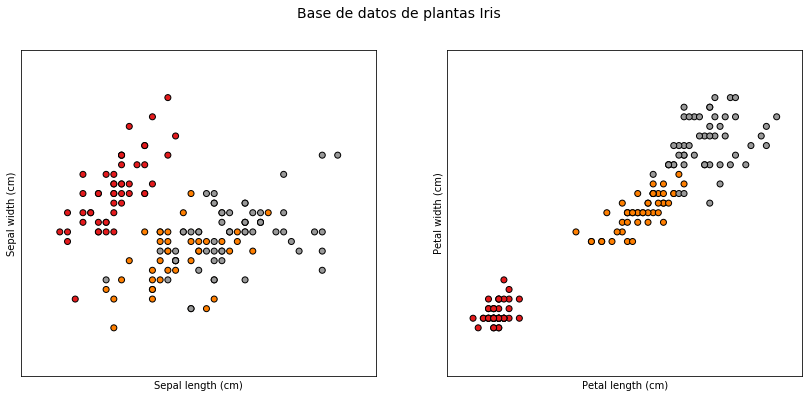

In [5]:
# Se extraen características y sus etiquetas correspondientes
X = iris.data     # características
y = iris.target   # clases o etiquetas, sólo se usan como referencia


# Visualización previa de las características por pares
# sirve para darnos una idea si será posible separar las clases

# Dos primeras características
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

# Características tercera y cuarta
x_min_2, x_max_2 = X[:, 2].min() - .5, X[:, 2].max() + .5
y_min_2, y_max_2 = X[:, 3].min() - .5, X[:, 3].max() + .5

# Gráficas por pares
fig = plt.figure(2, figsize=(14, 6))
plt.clf()
fig.suptitle("Base de datos de plantas Iris", fontsize=14)

# Grafica los datos de entrenamiento
plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1,
            edgecolor='k')
plt.xlabel(iris.feature_names[0].capitalize())
plt.ylabel(iris.feature_names[1].capitalize())

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c=y, cmap=plt.cm.Set1,
            edgecolor='k')
plt.xlabel(iris.feature_names[2].capitalize())
plt.ylabel(iris.feature_names[3].capitalize())

plt.xlim(x_min_2, x_max_2)
plt.ylim(y_min_2, y_max_2)
plt.xticks(())
plt.yticks(())

plt.show()

In [6]:
def ainfo(name, a):
    """
    Imprime el número de ejemplares y las dimensiones de los datos
    """
    print(name, a.shape, a.dtype)

In [7]:
X = iris.data
Y = iris.target
ainfo('X', X)
ainfo('Y', Y)

X (150, 4) float64
Y (150,) int64


# Entrenamiento de un mapeo autoorganizado de Kohonen (SOM)

In [8]:
import kohonen
from scipy.spatial import distance
import numpy as np
import random

In [9]:
# Documentación del paquete en:
# https://pythonhosted.org/kohonen/generated/kohonen.kohonen.Map.html#kohonen.kohonen.Map

kshape = (10,10)   # El mapa tendrá 10x10 neuronas
kmap = kohonen.Map(dimension=X.shape[1], shape=kshape)  # Por defecto se utiliza la distancia Euclidena

In [10]:
from ipywidgets import interact, interact_manual

In [11]:
# Entrena
random.seed(0)
num_entrena = X.shape[0]   # Usamos X.shape[0] para el entrenamiento
num_rondas = 100
@interact_manual
def entrena():
    distorsion = np.zeros(num_rondas)
    for round in range(num_rondas):
        # Se puede cambiar por un muestreo aleatorio
        error = 0
        for i in range(num_entrena):
            ind = random.randrange(0, num_entrena)
            #ind = i
            kmap.learn(X[ind])
            error += distance.euclidean(X[ind], kmap.neuron(kmap.flat_to_coords(kmap.winner(X[ind]))))
        distorsion[round] = error
    plt.plot(distorsion)
    plt.xlabel("Rondas")
    plt.ylabel("Distorsión")
    plt.title("Distorsión")

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…

## Mapa de calor por característica

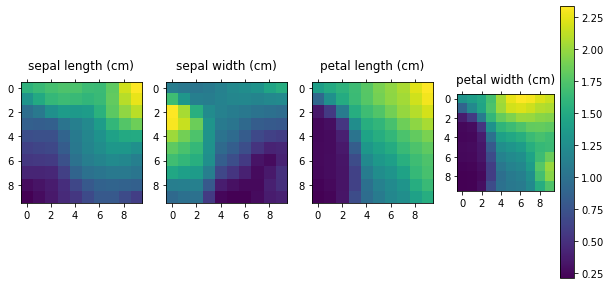

In [12]:
# Mapa de calor
# Muestra áreas para datos semejantes de colores semejantes

#plt.title("Mapa de calor", pad=20)
f, axarr = plt.subplots(1,4,figsize=(10,5)) # renglones, columnas
for i in range(kmap.neurons.shape[2]):
    cax = axarr[i].matshow(kmap.neurons[:,:,i])
    axarr[i].set_title(iris.feature_names[i])
    axarr[i].tick_params(axis='x', bottom=True, labelbottom=True, labeltop=False)

plt.colorbar(cax)



## Mapa de calor de distancias
Marca la distancia de todas las neuronas al vector de entrada

In [16]:
@interact(indice=(0, len(X)-1))
def grafica_distancia(indice):
    """ Muestra la distancia desde un vector hacia cada codebook. """
    cax = plt.matshow(kmap.distance_heatmap(X[indice]))
    plt.colorbar(cax)
    plt.title(iris.target_names[Y[indice]].capitalize() + ' ' + str(X[indice]), pad=20)

interactive(children=(IntSlider(value=74, description='indice', max=149), Output()), _dom_classes=('widget-int…

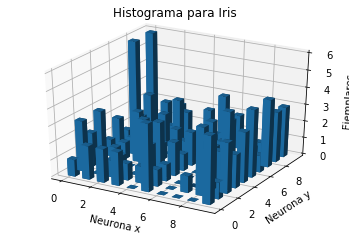

In [17]:
# Graficar el número de ejemplares por neurona en el mapa 2D
dz = np.zeros(kshape[0]*kshape[1])
for i in range(len(X)):
    dz[kmap.winner(X[i])] += 1

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Construct arrays for the anchor positions of the bars.
xpos, ypos = np.meshgrid(np.arange(kshape[0]), np.arange(kshape[0]), indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Construct arrays with the dimensions for the 16 bars.
dx = dy = 0.5 * np.ones_like(zpos)

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average', shade=True)

plt.xlabel("Neurona x")
plt.ylabel("Neurona y")
ax.set_zlabel("Ejemplares")
plt.title("Histograma para Iris", pad=10)
plt.show()
